In [1]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from tqdm.notebook import tqdm
import time
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import kwant
import math
from math import  sqrt
import cmath
from numpy.lib.scimath import sqrt as csqrt
import scipy
from scipy.optimize import fsolve
import copy

In [2]:
# Defining the Jordan Wigner transformation for a 1D lattice
def jordan_wigner_transform(j, lattice_length):
    for k in range(j):
        if k == 0:
            operators = sigmaz()
        else:
            operators = tensor(operators, sigmaz())
    if j == 0:
        operators = sigmap()
    else:
        operators = tensor(operators, sigmap())
    for k in range(lattice_length - j - 1):
        operators = tensor(operators, identity(2))
    return operators

# Define rho0 distribution
def Lorentzian(omega, Gamma, poles):
    Rho0 = Gamma / np.pi / (omega ** 2 + Gamma ** 2)
    p = np.random.uniform(0, 1, poles)
    Rhoint = np.zeros(poles)
    for i in range(len(p)):
        Rhoint[i] = Gamma * math.tan(np.pi * (p[i] - 1 / 2))  ###p[i]-1/2
    return Rho0, Rhoint

# Calculates parameters impengergy,bathenergy and Vkk from random sampling distribution
def nonintG(omega, eta, select):
    G = 0
    for i in range(len(select)):
        G = G + 1 / len(select) / (omega - select[i] + 1.j * eta)
    return G

def HamiltonianAIM(c, impengergy, bathenergy, Vkk, U, Sigma):
    H = 0
    for i in range(2):
        H += impengergy * (c[i].dag() * c[i])
        for j in range(len(bathenergy)):
            H += Vkk[j] * (c[i].dag() * c[2 * j + i + 2] + c[2 * j + i + 2].dag() * c[i])
            H += bathenergy[j] * (c[2 * j + i + 2].dag() * c[2 * j + i + 2])
    exp = np.dot(H.eigenstates()[1][0].dag(), np.dot(n, H.eigenstates()[1][0]))
    Eg=H.eigenstates()[0][0]
    H += U * (c[0].dag() * c[0] * c[1].dag() * c[1])
    H += -Sigma * (c[0].dag() * c[0] + c[1].dag() * c[1])
    return H,exp,Eg

def MBGAIM(omega, eigs, c, eta,Tk):
    #for t in range(len(Tk)):
    MBG=np.zeros(len(omega),dtype = 'complex_')
    Z=-eigs[0][0]/Tk
    for i in range(1,len(eigs[0])):
        Z = np.logaddexp(Z, -eigs[0][i]/Tk)
        #Z+=np.exp(-eigs[0][i]/Tk, dtype=np.longdouble)
    eigs2=copy.deepcopy(eigs[1])
    for i in range(len(eigs[1])):
        eigs2[i]=eigs2[i].dag()
    expA=np.reshape(eigs2,(len(eigs[1]),1))*c[0]*np.reshape(eigs[1],(1,len(eigs[1])))
    exp2A=np.reshape(eigs2,(len(eigs[1]),1))*c[0].dag()*np.reshape(eigs[1],(1,len(eigs[1])))
    for i in range(len(eigs[0])):
        for j in range(len(eigs[0])):
            #exp=np.dot(eigs[1][i].dag(),np.dot(c[0],eigs[1][j]))#m
            #exp2=np.dot(eigs[1][j].dag(),np.dot(c[0].dag(),eigs[1][i]))#j
            #exp3=np.dot(eigs[1][i].dag(),np.dot(c[0].dag(),eigs[1][j]))
            #exp4=np.dot(eigs[1][j].dag(),np.dot(c[0],eigs[1][i]))
            exp=expA[i][j]
            exp2=exp2A[j][i]
            exp3=exp2A[i][j]
            exp4=expA[j][i]
            k=exp[0][0][0]*exp2[0][0][0]
            l=exp3[0][0][0]*exp4[0][0][0]
            final = k / (omega + eigs[0][i] - eigs[0][j] + 1.j * eta) + l / (omega + eigs[0][j] - eigs[0][i] + 1.j * eta)
            ratio=-eigs[0][i]/Tk-Z
            MBG += final*np.exp(ratio)
            print("--- %s s second part %d %d %d ---" % ((time.time() - start_time) ,Tk,i,j), end='\r')
    #print(Z,-eigs[0][i]/Tk,ratio)
    return MBG

def find_nearest(array, value,eigs):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return eigs[idx]
#test this
def find_nearest2(array, value,eigs):
    for i in range(len(array)):
        if np.isclose(array[i], value, atol=0.1):
            idx=i
            break
    #print(array,value,idx)
    return eigs[idx]

# Gives Green’s function for the impurity level in the full interacting system (up and down spin)
def AIMsolver(impengergy, bathenergy, Vkk, U, Sigma, omega, eta, c,Tk,reset,error):
    H,exp2,Eg1 = HamiltonianAIM(c, impengergy, bathenergy, Vkk, U, Sigma)
    print("--- %s s first part ---" % ((time.time() - start_time)), end='\r')
    try:
        eigs=H.eigenstates()
    except np.linalg.LinAlgError:
        error=True
    exp = np.dot(eigs[1][0].dag(), np.dot(n, eigs[1][0]))
    MBG = np.full((len(Tk), len(omega)), np.zeros(len(omega),dtype = 'complex_'))
    if np.round(exp)==np.round(exp2):
        reset=True
        for t in range(len(Tk)):
            MBG[t] = MBGAIM(omega, eigs, c, eta,Tk[t])
    return MBG,reset,error

def Pcal(poles,pos):
    di=np.full((poles-1, poles), np.zeros(poles))
    for i in range(poles-1):
        for j in range(poles-1):
            if j>=i:
                di[i][j+1]=-1/sqrt((poles-i-1)*(poles-i))
        di[i][i]=sqrt(poles-i-1)/sqrt(poles-i)
    di=np.insert(di, pos,1/sqrt(poles),axis=0)
    return di

def DPgen(poles,select,pos):
    Pbath =np.array(Pcal(poles,pos))
    s = (poles,poles)
    Dbath=np.zeros(s)
    for i in range(len(select)):
        Dbath[i][i]=select[i]
    M=np.dot(Pbath,np.dot(Dbath,Pbath.T))
    return M

def startrans(poles,select,row,col):
    ham_mat=DPgen(poles,select,row)
    Hkk=np.delete(np.delete(ham_mat,row,axis=0),row,axis=1)
    eigkk,veckk=np.linalg.eig(Hkk)
    pbar=np.insert(np.insert(veckk, row,0,axis=0),row,0,axis=1)
    pbar[row][row]=1
    Hp=np.dot(pbar.T,np.dot(ham_mat,pbar))
    return Hp

In [3]:
omega= np.linspace(-3,3,1001)
N=2000
poles=4
U=3
Sigma=U/2
Gamma=0.3
lattice_length = 2+2*(poles-1)
c = []
for i in range(lattice_length):
    c.append(jordan_wigner_transform(i, lattice_length))
n=0
for i in range(lattice_length):
    n+=c[i].dag()*c[i]
Tk=[0.000000000001,0.001,0.01,0.1,1]
fDOS=np.full((len(Tk), len(omega)), np.zeros(len(omega),dtype = 'complex_'))
#noninttot3=0
#noninttot4=0
AvgSigmadat=np.full((len(Tk), len(omega)), np.zeros(len(omega),dtype = 'complex_'))
for i in tqdm(range(N)):
    start_time = time.time()
    attempts=0
    reset=False
    error=False
    while not reset:
        select=sorted(Lorentzian(omega, Gamma, poles)[1])
        NewM=startrans(poles,select,0,0)
        bathenergy=[]
        impengergy=NewM[0][0]
        for k in range(len(NewM)-1):
            bathenergy.append(NewM[k+1][k+1])
        Vkk=NewM[0,1:]
        eta=0.02*abs(omega)+0.000001
        MBGdat,reset,error=AIMsolver(impengergy, bathenergy, Vkk, U,Sigma,omega,eta,c,Tk,reset,error)
        if np.isnan(MBGdat).any() or error:
            reset=False
        #attempts+=1
    for l in range(len(Tk)):
        NewSigmadat=(1/nonintG(omega,eta,select)-1/MBGdat[l])/N
        AvgSigmadat[l]=AvgSigmadat[l]+NewSigmadat
        #noninttot3+=nonintG(omega,eta,select)/N
        #noninttot4+=MBGdat/N

--- 261.0208206176758 s second part 1 255 255 ----


(-0.012667689938023939-5.0014983584758695e-06j)


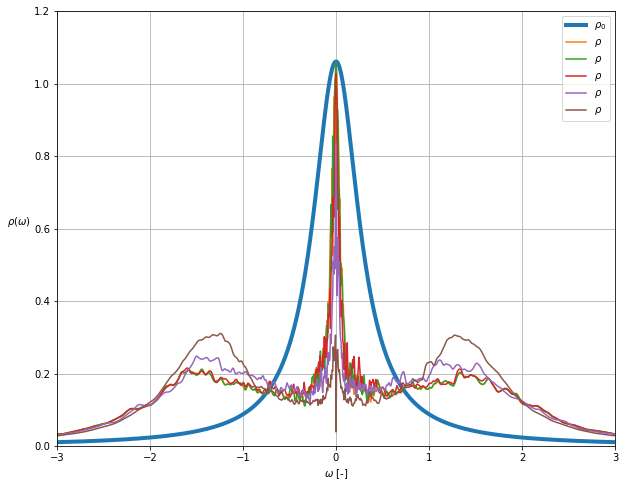

In [15]:
for l in range(len(Tk)):
    #AvgSigmadat+=Sigma
    #if l==0:
    #    Ed=-AvgSigmadat[500]
    finalG=np.nan_to_num(1/(omega-AvgSigmadat[l]+1j*Gamma))
    fDOS[l]=-np.imag(finalG)/np.pi
#print(BoltzmannT)
print(AvgSigmadat[0][500])
#fDOS3=-np.imag(noninttot3)/np.pi
#fDOS4=-np.imag(noninttot4)/np.pi
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.gca().set_ylim(bottom=0,top=1.2)
plt.xlabel("$\\omega$ [-]")
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.plot(omega,Lorentzian(omega,Gamma,poles)[0],linewidth=4,label='$\\rho_0$')
for i in range(len(Tk)):
    plt.plot(omega, fDOS[i],label='$\\rho$')
#plt.plot(omega, fDOS3,label='$\\rho$')
#plt.plot(omega, fDOS4,label='$\\rho$')
plt.legend()
plt.grid(b='on')
#print(Ed)

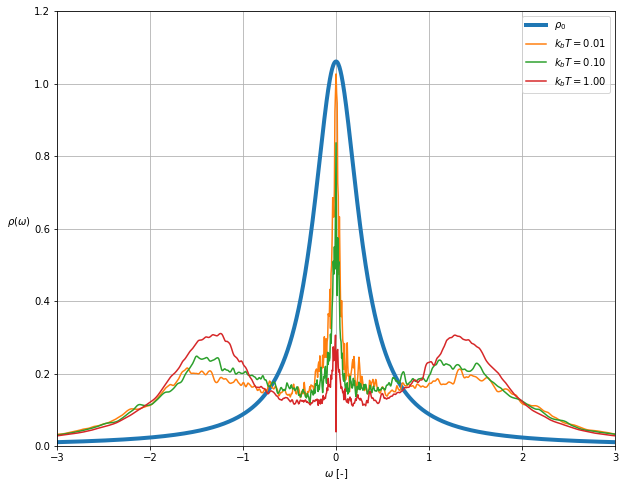

In [16]:
#fDOS3=-np.imag(noninttot3)/np.pi
#fDOS4=-np.imag(noninttot4)/np.pi
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.gca().set_ylim(bottom=0,top=1.2)
plt.xlabel("$\\omega$ [-]")
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.plot(omega,Lorentzian(omega,Gamma,poles)[0],linewidth=4,label='$\\rho_0$')
for i in range(2,len(Tk)):
    plt.plot(omega, fDOS[i],label='$k_bT= %.2f$'%Tk[i])
#plt.plot(omega, fDOS3,label='$\\rho$')
#plt.plot(omega, fDOS4,label='$\\rho$')
plt.legend()
plt.grid(b='on')

In [6]:
# Defining the Jordan Wigner transformation for a 1D lattice
def jordan_wigner_transform(j, lattice_length):
    for k in range(j):
        if k == 0:
            operators = sigmaz()
        else:
            operators = tensor(operators, sigmaz())
    if j == 0:
        operators = sigmap()
    else:
        operators = tensor(operators, sigmap())
    for k in range(lattice_length - j - 1):
        operators = tensor(operators, identity(2))
    return operators

# Define rho0 distribution
def Lorentzian(omega, Gamma, poles):
    Rho0 = Gamma / np.pi / (omega ** 2 + Gamma ** 2)
    p = np.random.uniform(0, 1, poles)
    Rhoint = np.zeros(poles)
    for i in range(len(p)):
        Rhoint[i] = Gamma * math.tan(np.pi * (p[i] - 1 / 2))  ###p[i]-1/2
    return Rho0, Rhoint

# Calculates parameters impengergy,bathenergy and Vkk from random sampling distribution
def nonintG(omega, eta, select):
    G = 0
    for i in range(len(select)):
        G = G + 1 / len(select) / (omega - select[i] + 1.j * eta)
    return G

def HamiltonianAIM(c, impengergy, bathenergy, Vkk, U, Sigma):
    H = 0
    for i in range(2):
        H += impengergy * (c[i].dag() * c[i])
        for j in range(len(bathenergy)):
            H += Vkk[j] * (c[i].dag() * c[2 * j + i + 2] + c[2 * j + i + 2].dag() * c[i])
            H += bathenergy[j] * (c[2 * j + i + 2].dag() * c[2 * j + i + 2])
    exp = np.dot(H.eigenstates()[1][0].dag(), np.dot(n, H.eigenstates()[1][0]))
    H += U * (c[0].dag() * c[0] * c[1].dag() * c[1])
    H += -Sigma * (c[0].dag() * c[0] + c[1].dag() * c[1])
    return H,exp

def MBGAIM(omega, eigs, c, eta):
    MBG = np.zeros(len(omega),dtype = 'complex_')
    for i in range(1, len(eigs[0])):
        exp=np.dot(eigs[1][i].dag(),np.dot(c[0],eigs[1][0]))#m
        exp2=np.dot(eigs[1][0].dag(),np.dot(c[0].dag(),eigs[1][i]))#j
        exp3=np.dot(eigs[1][i].dag(),np.dot(c[0].dag(),eigs[1][0]))
        exp4=np.dot(eigs[1][0].dag(),np.dot(c[0],eigs[1][i]))
        k=exp[0][0]*exp2[0][0]
        l=exp3[0][0]*exp4[0][0]
        final = k / (omega + eigs[0][i] - eigs[0][0] + 1.j * eta) + l / (omega + eigs[0][0] - eigs[0][i] + 1.j * eta)
        MBG += final
    return MBG

# Gives Green’s function for the impurity level in the full interacting system (up and down spin)
def AIMsolver(impengergy, bathenergy, Vkk, U, Sigma, omega, eta, c,reset):
    H,exp2 = HamiltonianAIM(c, impengergy, bathenergy, Vkk, U, Sigma)
    eigs=H.eigenstates()
    exp = np.dot(eigs[1][0].dag(), np.dot(n, eigs[1][0]))
    if exp==exp2:
        reset=True
    MBG = MBGAIM(omega, eigs, c, eta)
    return MBG,reset

def Pcal(poles,pos):
    di=np.full((poles-1, poles), np.zeros(poles))
    for i in range(poles-1):
        for j in range(poles-1):
            if j>=i:
                di[i][j+1]=-1/sqrt((poles-i-1)*(poles-i))
        di[i][i]=sqrt(poles-i-1)/sqrt(poles-i)
    di=np.insert(di, pos,1/sqrt(poles),axis=0)
    return di

def DPgen(poles,select,pos):
    Pbath =np.array(Pcal(poles,pos))
    s = (poles,poles)
    Dbath=np.zeros(s)
    for i in range(len(select)):
        Dbath[i][i]=select[i]
    M=np.dot(Pbath,np.dot(Dbath,Pbath.T))
    return M

def startrans(poles,select,row,col):
    ham_mat=DPgen(poles,select,row)
    Hkk=np.delete(np.delete(ham_mat,row,axis=0),row,axis=1)
    eigkk,veckk=np.linalg.eig(Hkk)
    pbar=np.insert(np.insert(veckk, row,0,axis=0),row,0,axis=1)
    pbar[row][row]=1
    Hp=np.dot(pbar.T,np.dot(ham_mat,pbar))
    return Hp

In [7]:
AvgSigmadat2=np.zeros(len(omega),dtype = 'complex_')
noninttot3=0
noninttot4=0
for i in tqdm(range(N)):
    reset=False
    while not reset:
        select=sorted(Lorentzian(omega, Gamma, poles)[1])
        NewM=startrans(poles,select,0,0)
        bathenergy=[]
        impengergy=NewM[0][0]
        for k in range(len(NewM)-1):
            bathenergy.append(NewM[k+1][k+1])
        Vkk=NewM[0,1:]
        MBGdat,reset=AIMsolver(impengergy, bathenergy, Vkk, U,Sigma,omega,eta,c,reset)
    NewSigmadat=1/nonintG(omega,eta,select)-1/MBGdat+Sigma
    AvgSigmadat2=AvgSigmadat2+NewSigmadat/N
    noninttot3+=nonintG(omega,eta,select)/N
    noninttot4+=MBGdat/N
    #print(AvgSigmadat[600]*N/(i+1)-Sigma, end='\r')

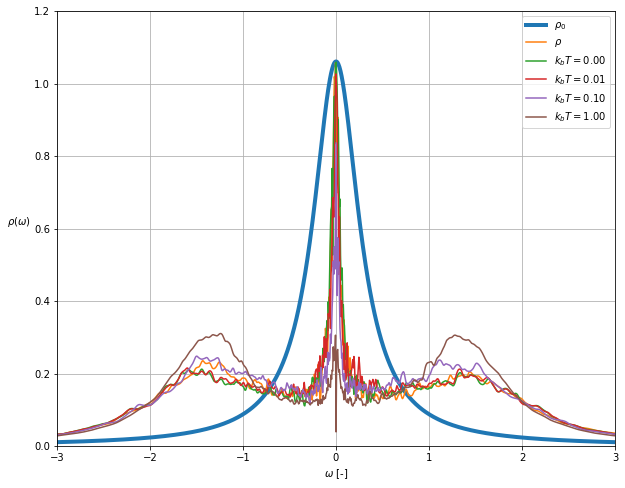

In [8]:
Ed=-Sigma
finalG2=np.nan_to_num(1/(omega-AvgSigmadat2-Ed+1j*Gamma))
fDOS2=-np.imag(finalG2)/np.pi
fDOS3=-np.imag(noninttot3)/np.pi
fDOS4=-np.imag(noninttot4)/np.pi
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.gca().set_ylim(bottom=0,top=1.2)
plt.xlabel("$\\omega$ [-]")
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.plot(omega,Lorentzian(omega,Gamma,poles)[0],linewidth=4,label='$\\rho_0$')
plt.plot(omega, fDOS2,label='$\\rho$')
plt.plot(omega, fDOS[0],label='$k_bT= %.2f$'%Tk[0])
for i in range(2,len(Tk)):
    plt.plot(omega, fDOS[i],label='$k_bT= %.2f$'%Tk[i])
#plt.plot(omega, fDOS3,label='$\\rho$')
#plt.plot(omega, fDOS4,label='$\\rho$')
plt.legend()
plt.grid(b='on')

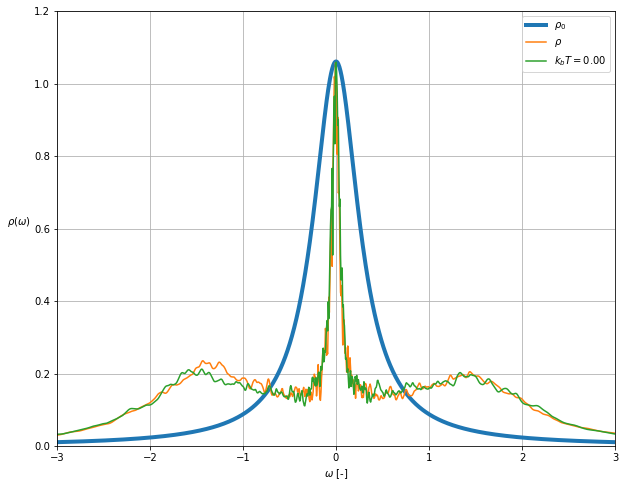

In [9]:
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.gca().set_ylim(bottom=0,top=1.2)
plt.xlabel("$\\omega$ [-]")
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.plot(omega,Lorentzian(omega,Gamma,poles)[0],linewidth=4,label='$\\rho_0$')
plt.plot(omega, fDOS2,label='$\\rho$')
plt.plot(omega, fDOS[0],label='$k_bT= %.2f$'%Tk[0])
#for i in range(2,len(Tk)):
    #plt.plot(omega, fDOS[i],label='$k_bT= %.2f$'%Tk[i])
#plt.plot(omega, fDOS3,label='$\\rho$')
#plt.plot(omega, fDOS4,label='$\\rho$')
plt.legend()
plt.grid(b='on')

In [10]:
FinSigmadat2=[omega,fDOS2,fDOS[0],fDOS[1],fDOS[2],fDOS[3],fDOS[4]]

np.savetxt('DEDTscv341',np.transpose(FinSigmadat2), fmt='%.18g', delimiter='\t', newline='\n')
text_file = open("DEDTscv341", "r")
lines = text_file.read().split('\n')
print(lines[0])
text_file.close()

 (-3+0j)	 (0.029826940872665908+0j)	 (0.0323792137793397009+0j)	 (0.0323555594189792184+0j)	 (0.0323031323037713883+0j)	 (0.0301222568332460937+0j)	 (0.0280379406236203783+0j)


In [17]:
FinSigmadat2=[omega,AvgSigmadat2,AvgSigmadat[0],AvgSigmadat[1],AvgSigmadat[2],AvgSigmadat[3],AvgSigmadat[4]]

np.savetxt('DEDTSigmadat',np.transpose(FinSigmadat2), fmt='%.18g', delimiter='\t', newline='\n')
text_file = open("DEDTSigmadat", "r")
lines = text_file.read().split('\n')
print(lines[0])
text_file.close()

 (-3+0j)	 (0.870831853560759983-0.255624260346064169j)	 (-0.613664589632265223-0.31813458448639631j)	 (-0.613734548668990798-0.317579328046743437j)	 (-0.612680156450842839-0.317019254020916852j)	 (-0.605177162248841549-0.27389829599048432j)	 (-0.628049231161231014-0.219329080020363776j)


(-0.012667689938023939-5.0014983584758695e-06j)


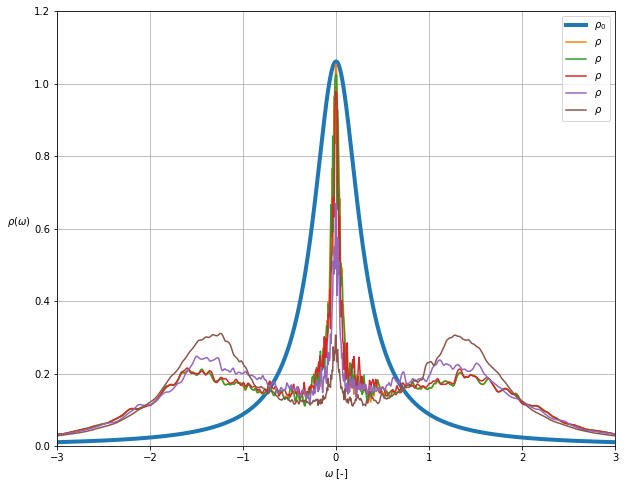

In [21]:
for l in range(len(Tk)):
    AvgSigmadat3=np.zeros(len(omega),dtype = 'complex_')
    for k in range(len(AvgSigmadat[l])):
        if omega[k]==0:
            AvgSigmadat3[k]=AvgSigmadat3[k-1]
        else:
            AvgSigmadat3[k]=AvgSigmadat[l][k]
    #AvgSigmadat+=Sigma
    #if l==0:
    #    Ed=-AvgSigmadat[500]
    finalG=np.nan_to_num(1/(omega-AvgSigmadat3+1j*Gamma))
    fDOS[l]=-np.imag(finalG)/np.pi
#print(BoltzmannT)
print(AvgSigmadat[0][500])
#fDOS3=-np.imag(noninttot3)/np.pi
#fDOS4=-np.imag(noninttot4)/np.pi
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.gca().set_ylim(bottom=0,top=1.2)
plt.xlabel("$\\omega$ [-]")
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.plot(omega,Lorentzian(omega,Gamma,poles)[0],linewidth=4,label='$\\rho_0$')
for i in range(len(Tk)):
    plt.plot(omega, fDOS[i],label='$\\rho$')
#plt.plot(omega, fDOS3,label='$\\rho$')
#plt.plot(omega, fDOS4,label='$\\rho$')
plt.legend()
plt.grid(b='on')

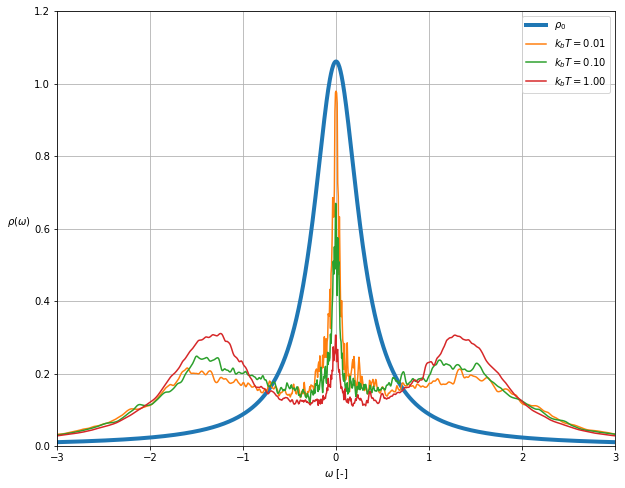

In [22]:
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.gca().set_ylim(bottom=0,top=1.2)
plt.xlabel("$\\omega$ [-]")
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.plot(omega,Lorentzian(omega,Gamma,poles)[0],linewidth=4,label='$\\rho_0$')
for i in range(2,len(Tk)):
    plt.plot(omega, fDOS[i],label='$k_bT= %.2f$'%Tk[i])
#plt.plot(omega, fDOS3,label='$\\rho$')
#plt.plot(omega, fDOS4,label='$\\rho$')
plt.legend()
plt.grid(b='on')